Notebook for read and wrangle of deforestation historical data

# Prepare environment

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import box

from tqdm import tqdm

In [2]:
import config

import warnings
warnings.filterwarnings('ignore')

# Data reading

In [3]:
# legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [4]:
# deter deforestation alerts
deter = gpd.read_file(config.DETER_DATA)

## Date format

In [ ]:
# datetime data formatting
deter["date"] = pd.to_datetime(deter["VIEW_DATE"])
deter["month"] = (deter["date"].dt.quarter - 1) * 3 + 1
deter["year"] = deter["date"].dt.year
deter["day"] = 1
deter["quarter_date"] = pd.to_datetime(deter[["year", "month", "day"]])

# Create full grid

In [ ]:
# get rectangle bounds from region
min_x, min_y, max_x, max_y = am_bounds.total_bounds
print(min_x, min_y, max_x, max_y)

-73.9909722199879 -18.04176667000001 -43.95182736291479 5.27222500000003


In [ ]:
# generate grid intersection with desired area
km_x = (max_x - min_x) / config.BOX_SIDE
km_y = (max_y - min_y) / config.BOX_SIDE
matrix_size_x = int(np.ceil(km_x))
matrix_size_y = int(np.ceil(km_y))
all_boxes = []
frame_idx = []  # list with indexes from each box
all_idx = []
idx = 0
for ix in tqdm(list(range(matrix_size_x))):
    for iy in range(matrix_size_y):
        frame = box(min_x+ix*config.BOX_SIDE, min_y+iy*config.BOX_SIDE, min_x+(ix+1)*config.BOX_SIDE, min_y+(iy+1)*config.BOX_SIDE)
        if am_bounds.intersects(frame).any():
            all_boxes.append(frame)
            all_idx.append(idx)
        frame_idx.append((ix, iy))
        idx += 1
frames = gpd.GeoDataFrame({"geometry": all_boxes}, crs=am_bounds.crs)
frames["frame_id"] = all_idx
frame_idx = np.array(frame_idx)

  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 301/301 [00:21<00:00, 13.80it/s]


# Compute temporal increments by frame

In [ ]:
increments_by_quarter = gpd.overlay(
    frames, 
    deter[["quarter_date", "geometry"]],
    how="intersection", 
    keep_geom_type=False
).dissolve(["frame_id", "quarter_date"]).reset_index()

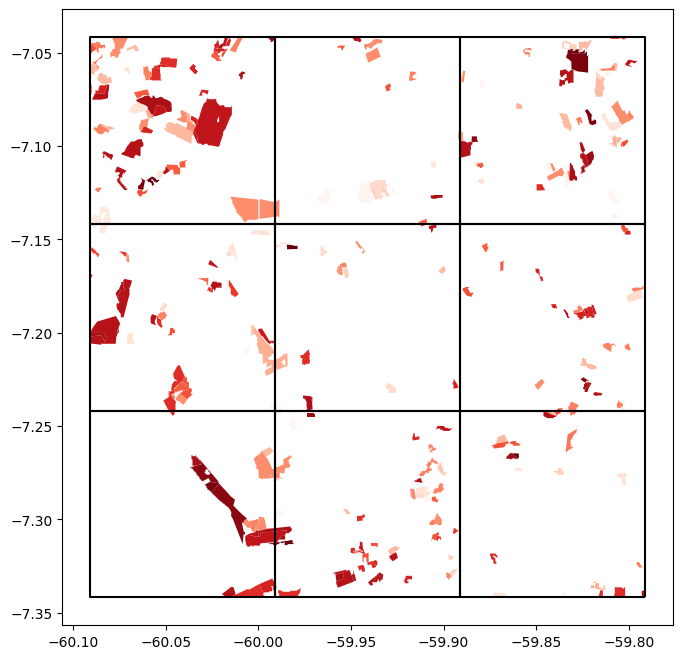

In [ ]:
frame_id_ = increments_by_quarter.sample()["frame_id"].item()
k = increments_by_quarter[
    ((increments_by_quarter["frame_id"] - frame_id_).abs() < 2) |
    ((increments_by_quarter["frame_id"] + matrix_size_y - frame_id_).abs() < 2) |
    ((increments_by_quarter["frame_id"] - matrix_size_y - frame_id_).abs() < 2)
].copy()
k["k"] = (k["quarter_date"] - k["quarter_date"].min()).dt.days
fig, ax = plt.subplots(figsize=(8, 8))
frames[
    ((frames["frame_id"] - frame_id_).abs() < 2) |
    ((frames["frame_id"] + matrix_size_y - frame_id_).abs() < 2) |
    ((frames["frame_id"] - matrix_size_y - frame_id_).abs() < 2)
].boundary.plot(ax=ax, color="black")
k.plot(column="k", ax=ax, cmap="Reds")
plt.show()

# Compute area by frame

In [ ]:
increments_by_quarter["area"] = increments_by_quarter["geometry"].area / increments_by_quarter["frame_id"].map(frames.set_index("frame_id").area)

In [ ]:
frame_idx = pd.DataFrame(frame_idx, columns=["x", "y"])
frame_idx["in_borders"] = False
frame_idx.loc[frames["frame_id"].values, "in_borders"] = True

In [ ]:
# save all frames geo-coordinates
frames.to_file(config.TR_FRAMES)

# save frames idx documentation
frame_idx.to_csv(config.TR_FRAMES_IDX)

# save increments history
increments_by_quarter[["frame_id", "quarter_date", "area"]].to_csv(config.TR_DEFORESTATION)